## DATA LOADING

In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class PaddedSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        # Filter and sort valid image filenames
        self.filenames = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, os.path.splitext(fname)[0] + ".png")

        # Load image and corresponding mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        target_h, target_w = 640, 1024
        w, h = image.size

        # Pad only height if needed (width assumed fixed)
        if h < target_h:
            pad_h = target_h - h
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            padding = (0, pad_top, 0, pad_bottom)  # left, top, right, bottom
            image = TF.pad(image, padding, fill=0)
            mask = TF.pad(mask, padding, fill=0)

        # Convert to tensor
        image_tensor = TF.to_tensor(image)

        # Process mask to class labels: 0 (background), 1 (crack), 2 (pothole)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_np = np.where(mask_np == 255, 2, np.where(mask_np == 127, 1, 0))
        mask_tensor = torch.from_numpy(mask_np).long()

        return image_tensor, mask_tensor

In [2]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

# Root directory of your segmentation dataset
root_dir = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset"

# Create datasets
train_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "train", "images"),
    masks_dir=os.path.join(root_dir, "train", "masks")
)
val_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "val", "images"),
    masks_dir=os.path.join(root_dir, "val", "masks")
)
test_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "test", "images"),
    masks_dir=os.path.join(root_dir, "test", "masks")
)

# Create data loaders (global scope)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Quick test to verify loading
for imgs, masks in tqdm(train_loader, desc="Loading train batches"):
    print("Image batch:", imgs.shape)  # e.g. [8, 3, 640, 1024]
    print("Mask batch:", masks.shape)  # e.g. [8, 640, 1024]
    break

Loading train batches:   0%|                                                                   | 0/224 [00:00<?, ?it/s]

Image batch: torch.Size([8, 3, 640, 1024])
Mask batch: torch.Size([8, 640, 1024])


## TRAINING

In [3]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

In [4]:
# Define UNet model with MobileNetV2 encoder
model = smp.Unet(
    encoder_name="mobilenet_v2",        # MobileNetV2 as backbone
    encoder_weights="imagenet",         # Pretrained on ImageNet
    in_channels=3,                      # RGB images
    classes=3                           # 3 classes: {0, 1, 2}
)

In [5]:
import torch

# Best device practice
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optional but helpful for consistent input sizes (improves cuDNN performance)
torch.backends.cudnn.benchmark = True

# Move model to device
model = model.to(device)
print(f"📟 Using device: {device}")

📟 Using device: cuda


In [6]:
# Block 3 - Modified
import torch.nn as nn
import torch.optim as optim

# Class weights - adjust these based on your dataset statistics
class_weights = torch.tensor([0.1, 2.0, 1.5])  # [background, crack, pothole]
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer remains the same
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch
from tqdm import tqdm
import os
import time

# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=10,
    save_path="best_model_mobilenetv2.pth",
    checkpoint_path="checkpoint_mobilenetv2.pth",
    pause_file="pause_mobilenetv2.flag",
    epoch_save_dir=r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2"
):
    os.makedirs(epoch_save_dir, exist_ok=True)
    start_epoch = 0
    best_val_loss = float('inf')

    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print("🔁 Resuming from checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        print(f"➡️ Resumed from epoch {start_epoch}, Best Val Loss so far: {best_val_loss:.4f}")

    model.to(device)

    for epoch in range(start_epoch, num_epochs):
        # Pause check
        while os.path.exists(pause_file):
            print("⏸️ Training paused. Remove 'pause_mobilenetv2.flag' to resume.")
            time.sleep(5)

        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)

        for images, masks in loop:
            while os.path.exists(pause_file):
                print("⏸️ Training paused. Remove 'pause_mobilenetv2.flag' to resume.")
                time.sleep(5)

            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"\n📘 Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

        val_loss = validate(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved! Val Loss = {best_val_loss:.4f}")

        # Save checkpoint after every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"💾 Checkpoint saved at epoch {epoch+1}")

        # Save model for this specific epoch
        epoch_model_path = os.path.join(epoch_save_dir, f"model_epoch_{epoch+1:02d}.pth")
        torch.save(model.state_dict(), epoch_model_path)
        print(f"📦 Model for epoch {epoch+1} saved at: {epoch_model_path}")

# Validation function remains unchanged
@torch.no_grad()
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0

    for images, masks in tqdm(val_loader, desc="🔍 Validating", leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"🔎 Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

In [8]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    save_path="unet_mobilenetv2_segmentation.pth",
    checkpoint_path="checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_8256\1053430754.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 48, Best Val Loss so far: 0.0269


In [15]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,  # Changed from 5 to 10
    save_path="unet_mobilenetv2_segmentation.pth",
    checkpoint_path="checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_13536\1974027587.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

➡️ Resumed from epoch 5, Best Val Loss so far: 0.0374



📘 Epoch 6: Avg Train Loss = 0.0330


🔎 Validation Loss: 0.0329
✅ Best model saved! Val Loss = 0.0329
💾 Checkpoint saved at epoch 6



📘 Epoch 7: Avg Train Loss = 0.0291


🔎 Validation Loss: 0.0301
✅ Best model saved! Val Loss = 0.0301
💾 Checkpoint saved at epoch 7



📘 Epoch 8: Avg Train Loss = 0.0265


🔎 Validation Loss: 0.0306
💾 Checkpoint saved at epoch 8



📘 Epoch 9: Avg Train Loss = 0.0244


🔎 Validation Loss: 0.0269
✅ Best model saved! Val Loss = 0.0269
💾 Checkpoint saved at epoch 9



📘 Epoch 10: Avg Train Loss = 0.0227


🔎 Validation Loss: 0.0269
✅ Best model saved! Val Loss = 0.0269
💾 Checkpoint saved at epoch 10


In [8]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=60,
    save_path="unet_mobilenetv2_segmentation.pth",
    checkpoint_path="checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_1896\1053430754.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 59, Best Val Loss so far: 0.0269



📘 Epoch 60: Avg Train Loss = 0.0353


🔎 Validation Loss: 0.1822
💾 Checkpoint saved at epoch 60
📦 Model for epoch 60 saved at: C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_60.pth


## Performance after 5 epochs

In [9]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [17]:
model.load_state_dict(torch.load("unet_mobilenetv2_segmentation.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_13536\4155246022.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_mobilenetv2_segmentat

<All keys matched successfully>


📊 Performance Metrics:
Pixel Accuracy: 0.9907
Per-class Accuracy:
  Background: 0.9979
  Crack: 0.3920
  Pothole: 0.5869
IoU per class:
  Background: 0.9907
  Crack: 0.3397
  Pothole: 0.4837
Mean IoU: 0.6047


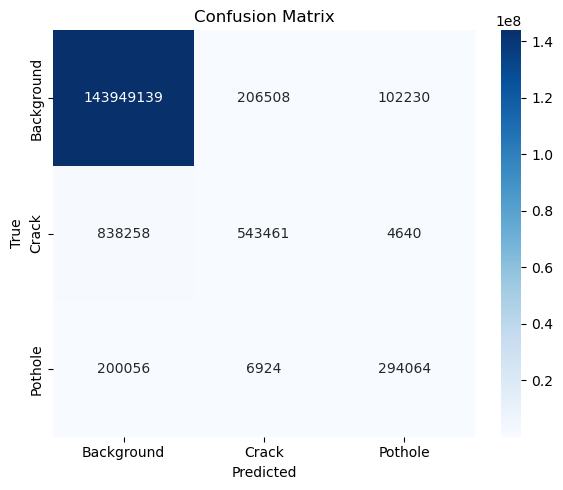

In [11]:
compute_metrics(model, val_loader)  # Test on validation set


📊 Performance Metrics:
Pixel Accuracy: 0.9908
Per-class Accuracy:
  Background: 0.9979
  Crack: 0.4035
  Pothole: 0.5923
IoU per class:
  Background: 0.9909
  Crack: 0.3453
  Pothole: 0.5079
Mean IoU: 0.6147


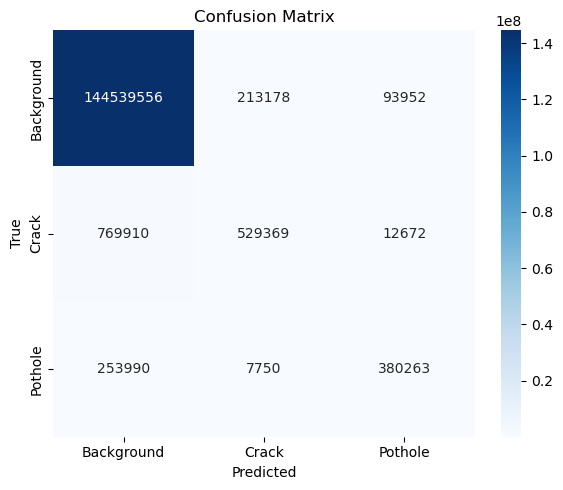

In [12]:
compute_metrics(model, test_loader)  # Test on test set

## Performance after 10 epochs


📊 Performance Metrics:
Pixel Accuracy: 0.9915
Per-class Accuracy:
  Background: 0.9974
  Crack: 0.4797
  Pothole: 0.7034
IoU per class:
  Background: 0.9915
  Crack: 0.4009
  Pothole: 0.5754
Mean IoU: 0.6559


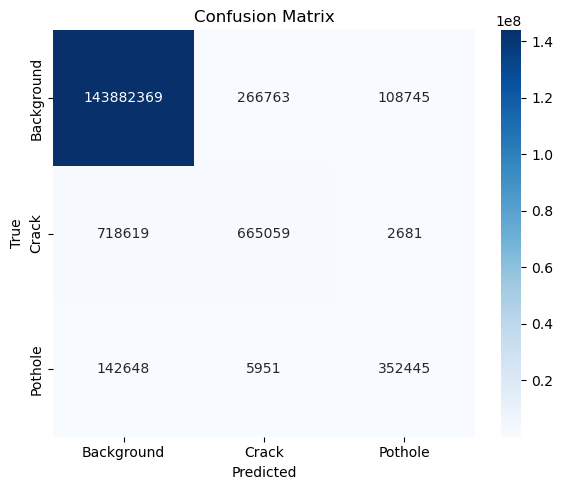

In [18]:
compute_metrics(model, val_loader)  # Test on validation set


📊 Performance Metrics:
Pixel Accuracy: 0.9913
Per-class Accuracy:
  Background: 0.9973
  Crack: 0.4863
  Pothole: 0.6720
IoU per class:
  Background: 0.9913
  Crack: 0.3979
  Pothole: 0.5640
Mean IoU: 0.6511


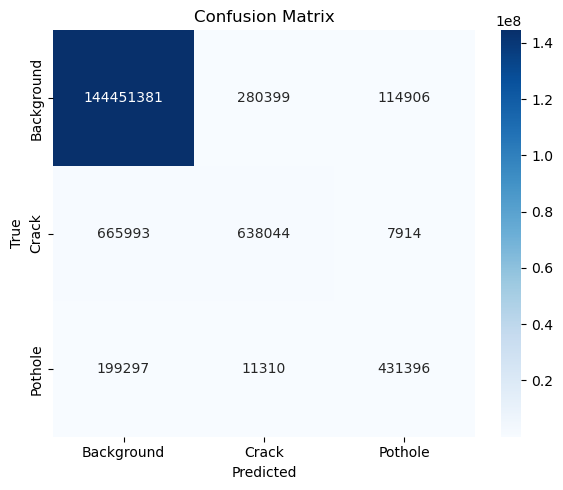

In [19]:
compute_metrics(model, test_loader)  # Test on test set

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()

            batch_size = images.shape[0]
            for i in range(batch_size):
                if images_shown >= num_images:
                    return

                img = np.transpose(images[i], (1, 2, 0))  # CHW to HWC
                gt_mask = masks[i]
                pred_mask = preds[i]

                # Create a figure with 3 subplots: input image, ground truth mask, predicted mask
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                axs[1].imshow(gt_mask, cmap='jet', vmin=0, vmax=2)
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis('off')

                axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=2)
                axs[2].set_title("Predicted Mask")
                axs[2].axis('off')

                plt.show()
                images_shown += 1

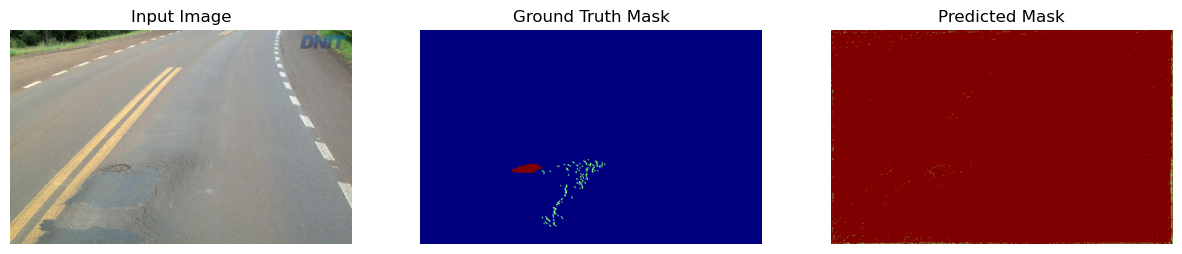

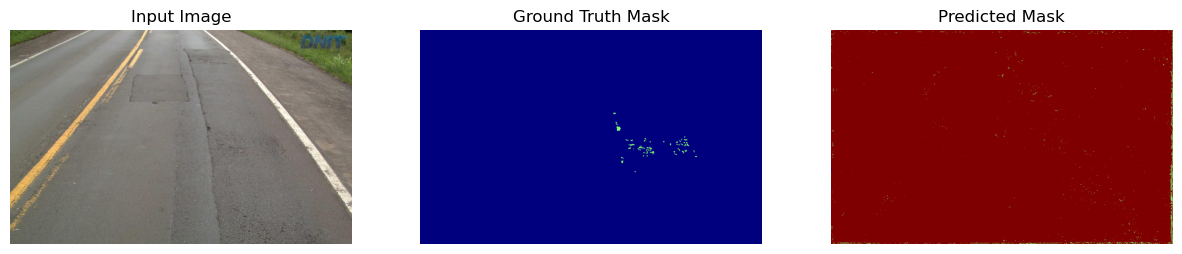

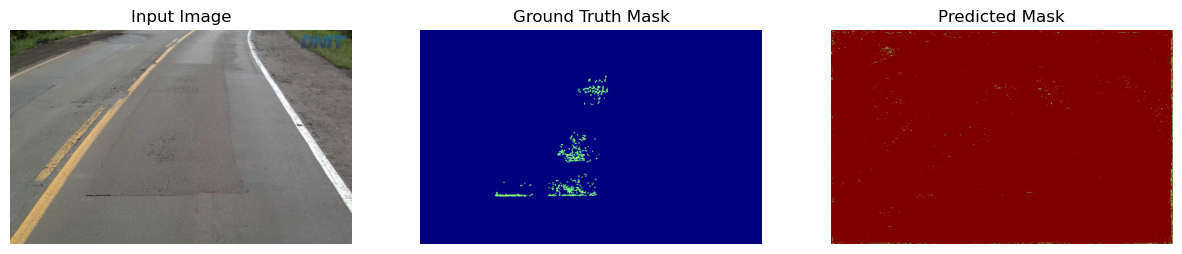

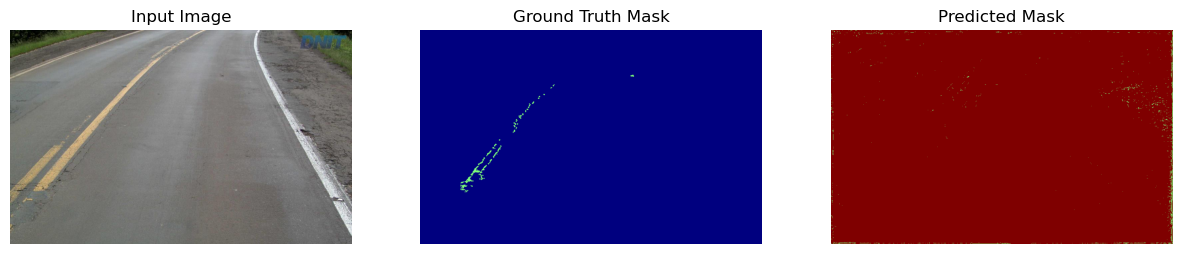

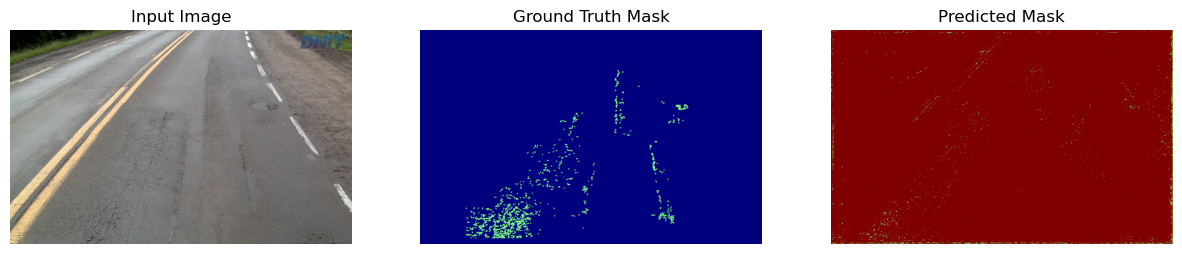

In [9]:
visualize_predictions(model, val_loader, device, num_images=5)

## Performance till 30 epochs

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1023618500.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9658
Per-class Accuracy:
  Background: 0.9666
  Crack: 0.8983
  Pothole: 0.9213
IoU per class:
  Background: 0.9657
  Crack: 0.2369
  Pothole: 0.3185
Mean IoU: 0.5070


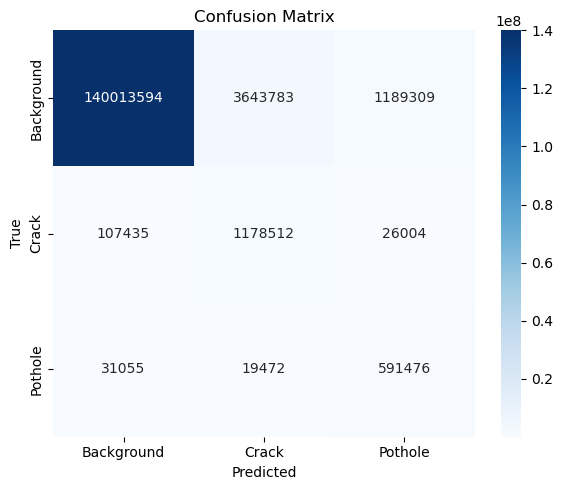

In [10]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_11.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1167284310.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9710
Per-class Accuracy:
  Background: 0.9723
  Crack: 0.9050
  Pothole: 0.8150
IoU per class:
  Background: 0.9709
  Crack: 0.2470
  Pothole: 0.4401
Mean IoU: 0.5527


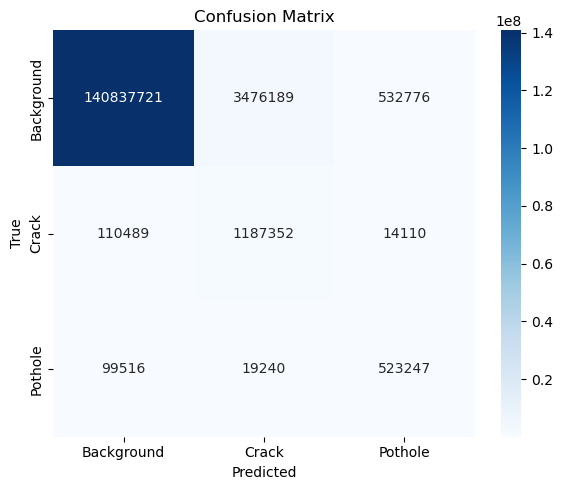

In [11]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_12.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1233958520.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9772
Per-class Accuracy:
  Background: 0.9789
  Crack: 0.8895
  Pothole: 0.7808
IoU per class:
  Background: 0.9772
  Crack: 0.2857
  Pothole: 0.5167
Mean IoU: 0.5932


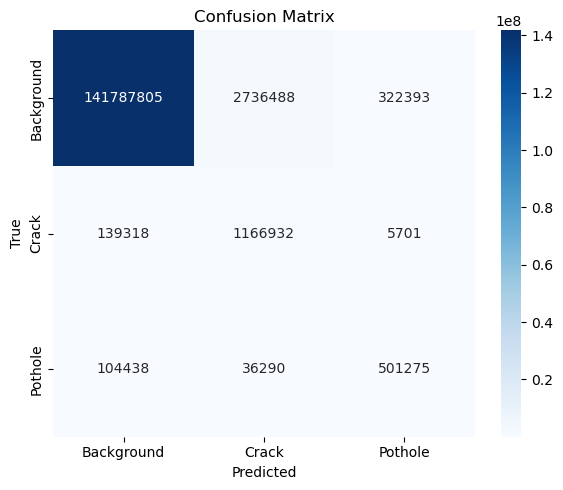

In [12]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_13.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\3902957786.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9807
Per-class Accuracy:
  Background: 0.9822
  Crack: 0.8634
  Pothole: 0.8681
IoU per class:
  Background: 0.9807
  Crack: 0.3216
  Pothole: 0.5344
Mean IoU: 0.6122


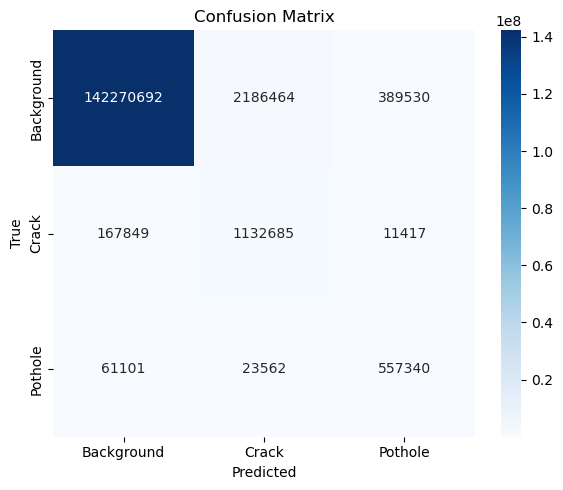

In [13]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_14.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1542959350.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9777
Per-class Accuracy:
  Background: 0.9793
  Crack: 0.8998
  Pothole: 0.7659
IoU per class:
  Background: 0.9777
  Crack: 0.2865
  Pothole: 0.5706
Mean IoU: 0.6116


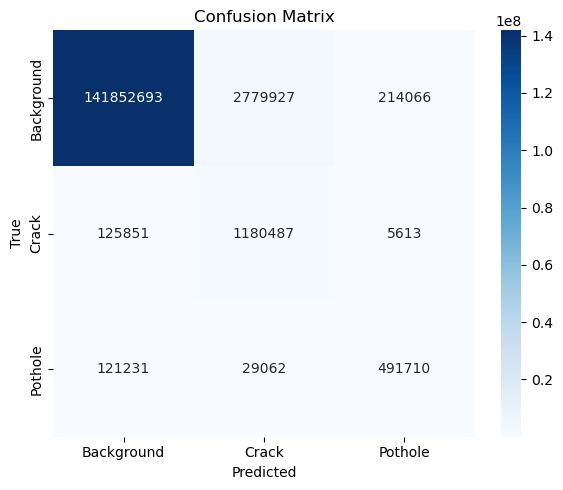

In [14]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_15.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1073710195.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9819
Per-class Accuracy:
  Background: 0.9837
  Crack: 0.8537
  Pothole: 0.8449
IoU per class:
  Background: 0.9819
  Crack: 0.3283
  Pothole: 0.5765
Mean IoU: 0.6289


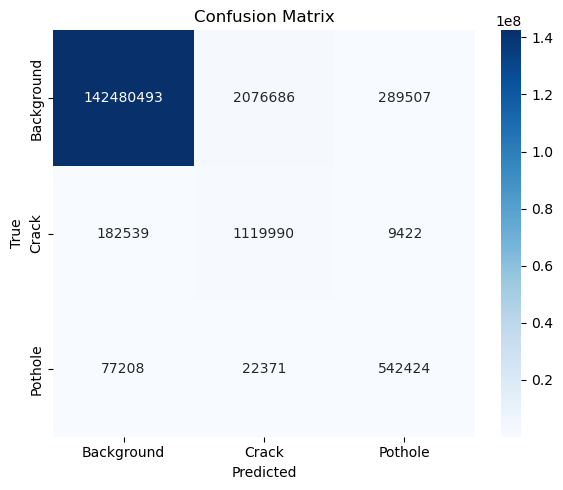

In [15]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_16.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\3454032689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9795
Per-class Accuracy:
  Background: 0.9809
  Crack: 0.8859
  Pothole: 0.8546
IoU per class:
  Background: 0.9795
  Crack: 0.3049
  Pothole: 0.5878
Mean IoU: 0.6241


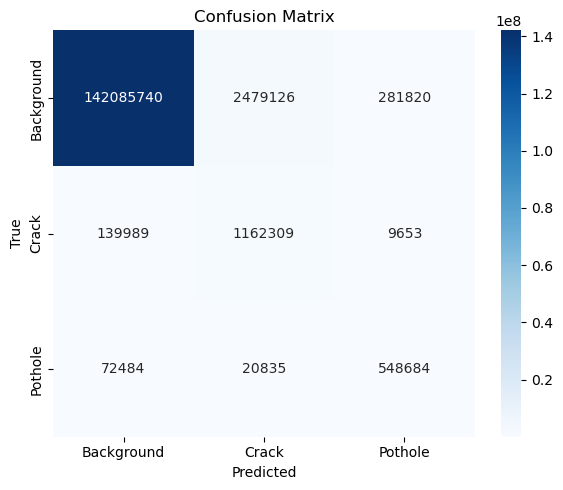

In [16]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_17.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1058450109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9785
Per-class Accuracy:
  Background: 0.9798
  Crack: 0.8903
  Pothole: 0.8677
IoU per class:
  Background: 0.9785
  Crack: 0.2986
  Pothole: 0.5590
Mean IoU: 0.6120


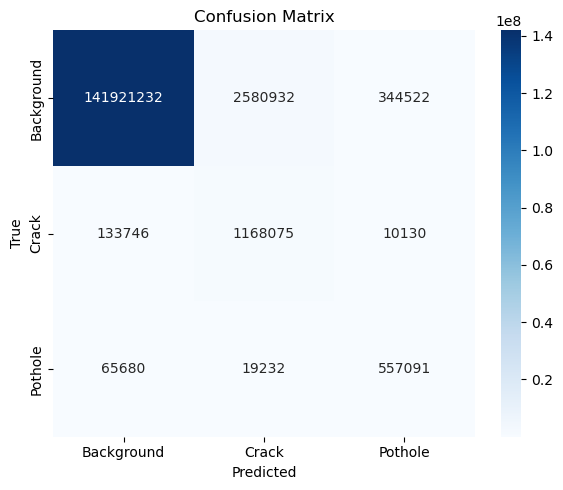

In [17]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_18.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\941510483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnct


📊 Performance Metrics:
Pixel Accuracy: 0.9825
Per-class Accuracy:
  Background: 0.9843
  Crack: 0.8620
  Pothole: 0.8252
IoU per class:
  Background: 0.9825
  Crack: 0.3334
  Pothole: 0.6049
Mean IoU: 0.6403


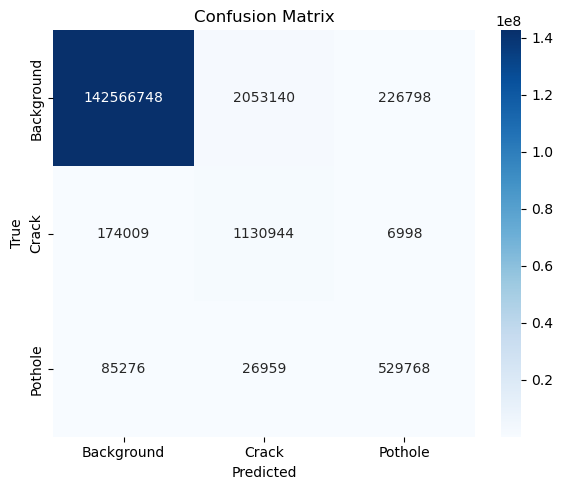

In [18]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_19.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\2454613689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9850
Per-class Accuracy:
  Background: 0.9874
  Crack: 0.8389
  Pothole: 0.7343
IoU per class:
  Background: 0.9850
  Crack: 0.3708
  Pothole: 0.5601
Mean IoU: 0.6387


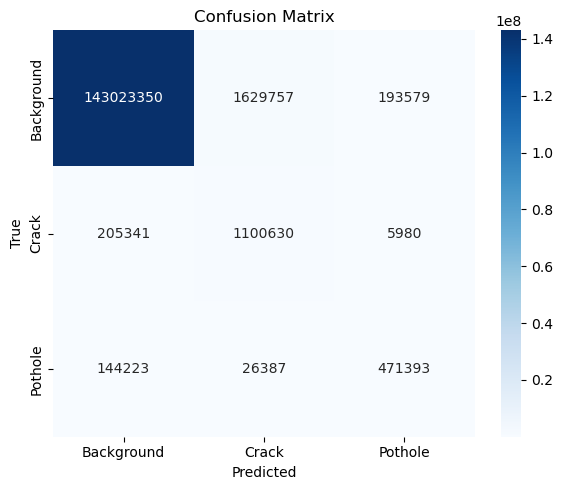

In [19]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_20.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\3005766024.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9802
Per-class Accuracy:
  Background: 0.9820
  Crack: 0.8876
  Pothole: 0.7546
IoU per class:
  Background: 0.9802
  Crack: 0.3093
  Pothole: 0.5910
Mean IoU: 0.6268


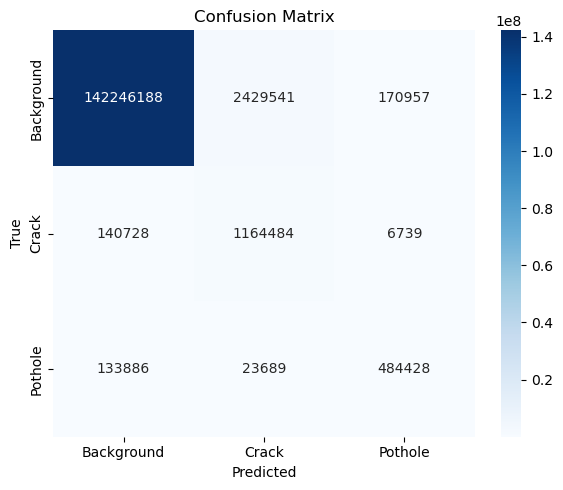

In [20]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_21.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\44510821.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd


📊 Performance Metrics:
Pixel Accuracy: 0.9842
Per-class Accuracy:
  Background: 0.9860
  Crack: 0.8442
  Pothole: 0.8638
IoU per class:
  Background: 0.9842
  Crack: 0.3620
  Pothole: 0.5811
Mean IoU: 0.6424


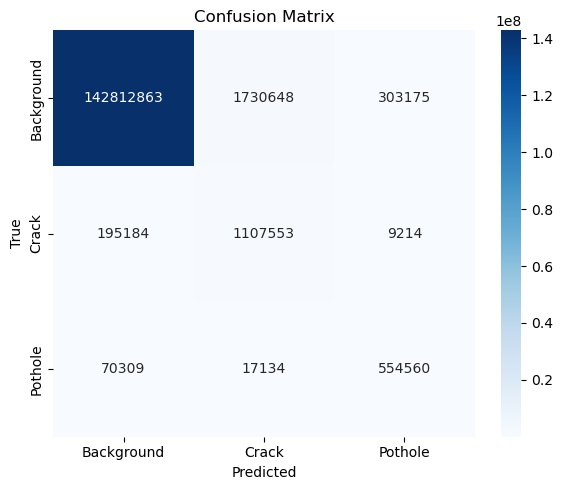

In [21]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_22.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\4127440111.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9802
Per-class Accuracy:
  Background: 0.9819
  Crack: 0.8946
  Pothole: 0.7750
IoU per class:
  Background: 0.9802
  Crack: 0.3116
  Pothole: 0.5915
Mean IoU: 0.6278


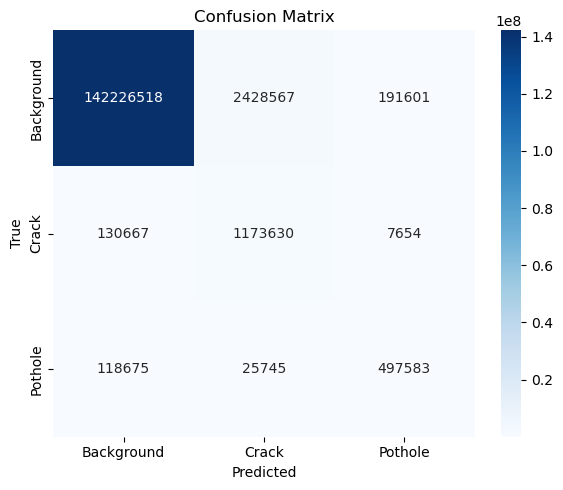

In [22]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_23.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\3850034551.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9833
Per-class Accuracy:
  Background: 0.9851
  Crack: 0.8516
  Pothole: 0.8404
IoU per class:
  Background: 0.9833
  Crack: 0.3468
  Pothole: 0.5878
Mean IoU: 0.6393


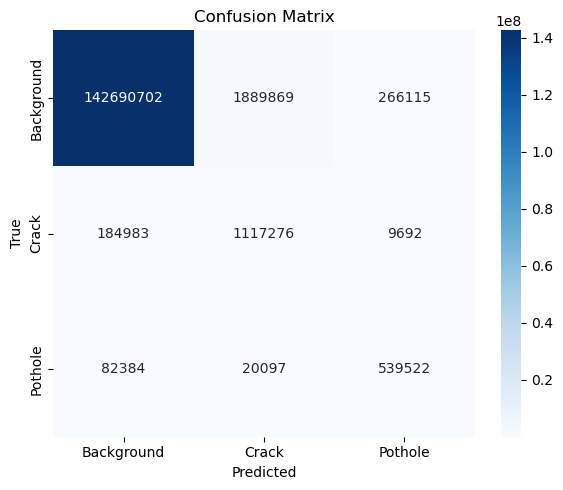

In [23]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_24.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\2808717396.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9839
Per-class Accuracy:
  Background: 0.9860
  Crack: 0.8592
  Pothole: 0.7499
IoU per class:
  Background: 0.9839
  Crack: 0.3555
  Pothole: 0.5706
Mean IoU: 0.6367


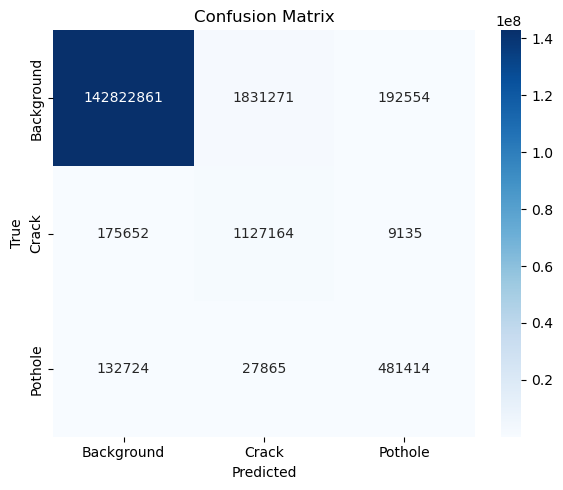

In [24]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_25.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\771957579.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnct


📊 Performance Metrics:
Pixel Accuracy: 0.9869
Per-class Accuracy:
  Background: 0.9896
  Crack: 0.7852
  Pothole: 0.8082
IoU per class:
  Background: 0.9870
  Crack: 0.3987
  Pothole: 0.5701
Mean IoU: 0.6519


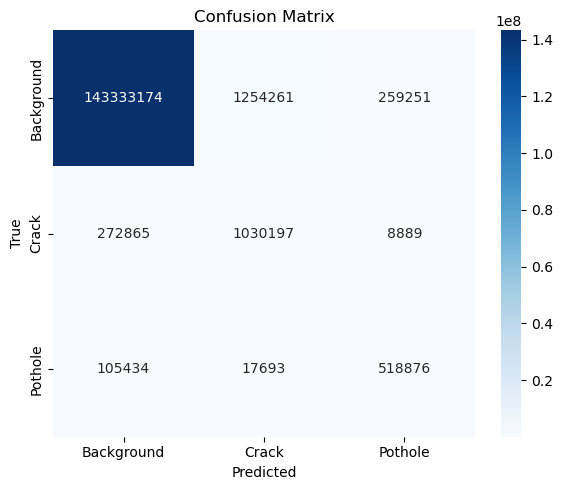

In [25]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_26.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\397593912.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnct


📊 Performance Metrics:
Pixel Accuracy: 0.9767
Per-class Accuracy:
  Background: 0.9783
  Crack: 0.9133
  Pothole: 0.7521
IoU per class:
  Background: 0.9767
  Crack: 0.2784
  Pothole: 0.5818
Mean IoU: 0.6123


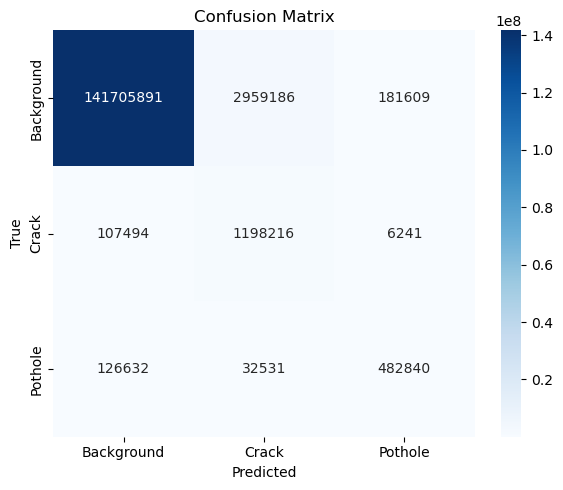

In [26]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_27.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\1337560999.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9831
Per-class Accuracy:
  Background: 0.9849
  Crack: 0.8689
  Pothole: 0.8139
IoU per class:
  Background: 0.9831
  Crack: 0.3449
  Pothole: 0.6021
Mean IoU: 0.6433


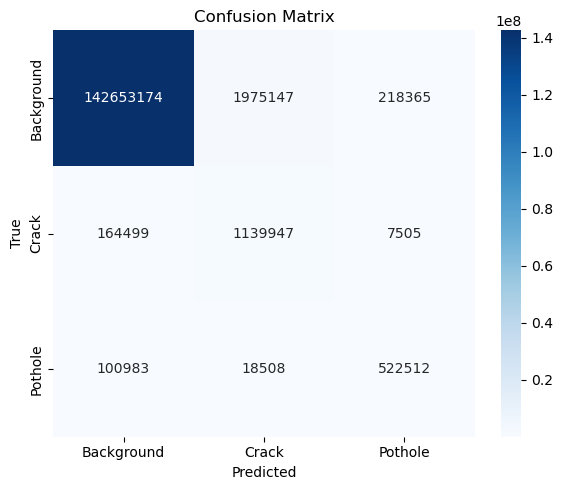

In [27]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_28.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\4253909215.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9859
Per-class Accuracy:
  Background: 0.9882
  Crack: 0.8240
  Pothole: 0.8093
IoU per class:
  Background: 0.9860
  Crack: 0.3837
  Pothole: 0.5914
Mean IoU: 0.6537


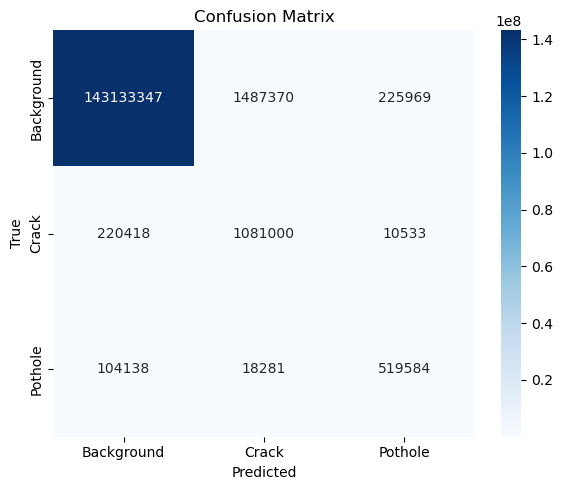

In [28]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_29.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_9496\2377709145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9799
Per-class Accuracy:
  Background: 0.9815
  Crack: 0.8962
  Pothole: 0.8012
IoU per class:
  Background: 0.9799
  Crack: 0.3117
  Pothole: 0.5714
Mean IoU: 0.6210


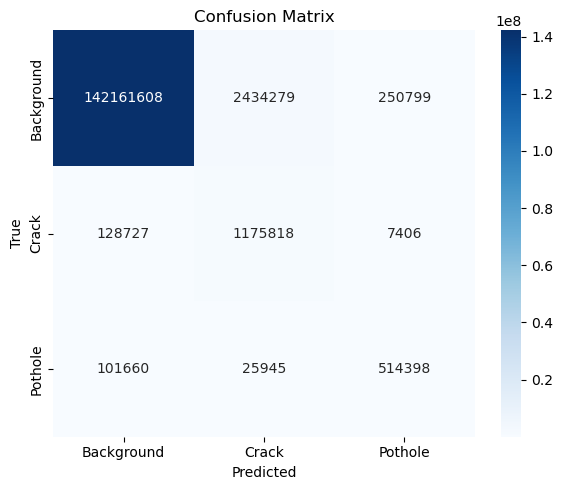

In [29]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_30.pth"))
compute_metrics(model, test_loader)  # Test on test set

## Best Model Visualization

In [37]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()

            batch_size = images.shape[0]
            for i in range(batch_size):
                if images_shown >= num_images:
                    return

                img = np.transpose(images[i], (1, 2, 0))  # CHW to HWC
                gt_mask = masks[i]
                pred_mask = preds[i]

                # Create a figure with 3 subplots: input image, ground truth mask, predicted mask
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                axs[1].imshow(gt_mask, cmap='jet', vmin=0, vmax=2)
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis('off')

                axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=2)
                axs[2].set_title("Predicted Mask")
                axs[2].axis('off')

                plt.show()
                images_shown += 1

In [8]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_11.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_24648\3412431891.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn

<All keys matched successfully>

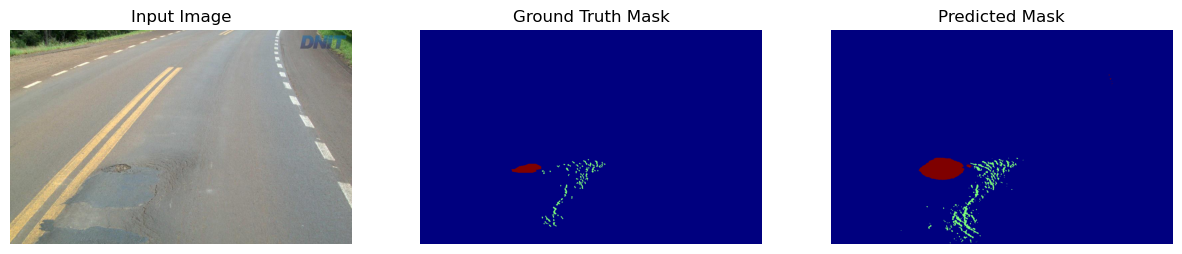

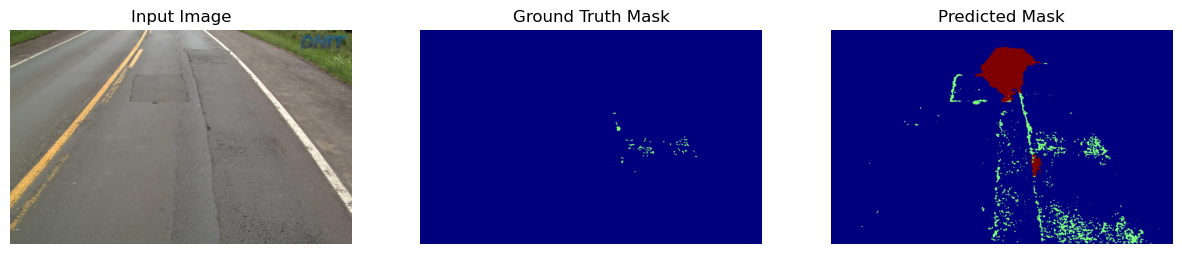

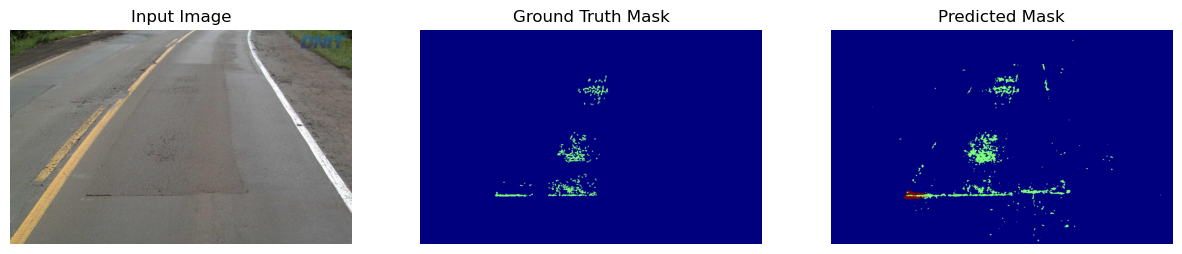

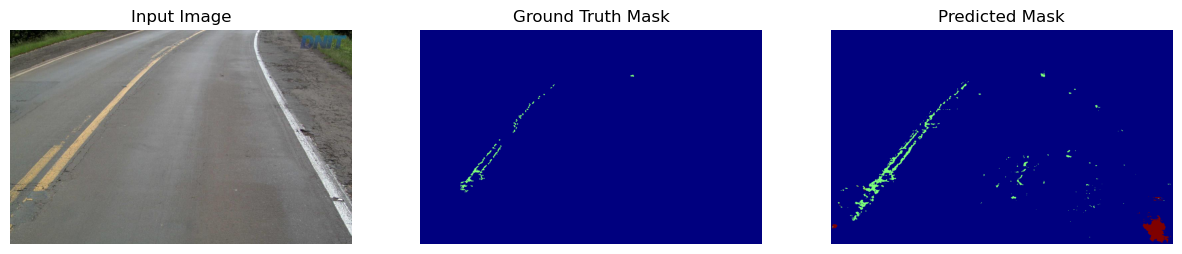

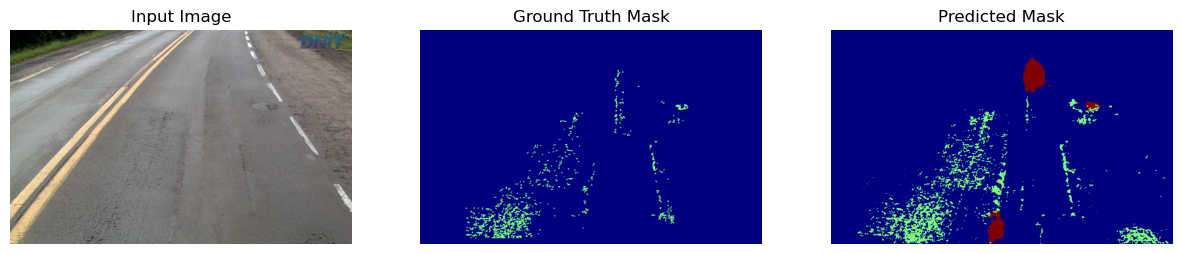

In [39]:
visualize_predictions(model, val_loader, device, num_images=5)

In [13]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

       # Normalized confusion matrix
    cm_normalized = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0)
    support = np.array([(all_labels == i).sum() for i in range(NUM_CLASSES)])

    print("\n📋 Classification Report:")
    print(f"{'Class':<12} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'IoU':>10} {'Support':>10}")
    print("-" * 60)
    for i in range(NUM_CLASSES):
        print(f"{CLASS_NAMES[i]:<12} {precision[i]:10.4f} {recall[i]:10.4f} {f1[i]:10.4f} {ious[i]:10.4f} {support[i]:10}")

    # Macro averages
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()
    mean_iou = np.mean(ious)

    print("-" * 60)
    print(f"{'Average':<12} {macro_precision:10.4f} {macro_recall:10.4f} {macro_f1:10.4f} {mean_iou:10.4f} {support.sum():10}")



📊 Performance Metrics:
Pixel Accuracy: 0.9658
Per-class Accuracy:
  Background: 0.9666
  Crack: 0.8983
  Pothole: 0.9213
IoU per class:
  Background: 0.9657
  Crack: 0.2369
  Pothole: 0.3185
Mean IoU: 0.5070


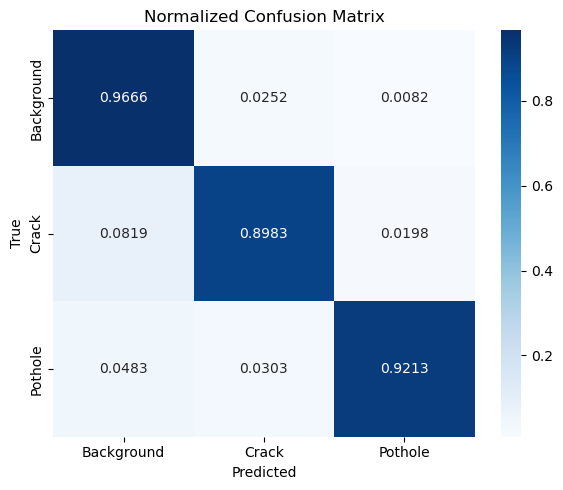


📋 Classification Report:
Class         Precision     Recall   F1-score        IoU    Support
------------------------------------------------------------
Background       0.9990     0.9666     0.9826     0.9657  144846686
Crack            0.2434     0.8983     0.3831     0.2369    1311951
Pothole          0.3274     0.9213     0.4831     0.3185     642003
------------------------------------------------------------
Average          0.5233     0.9287     0.6162     0.5070  146800640


In [14]:
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_24648\2377709145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9799
Per-class Accuracy:
  Background: 0.9815
  Crack: 0.8962
  Pothole: 0.8015
IoU per class:
  Background: 0.9799
  Crack: 0.3117
  Pothole: 0.5715
Mean IoU: 0.6210


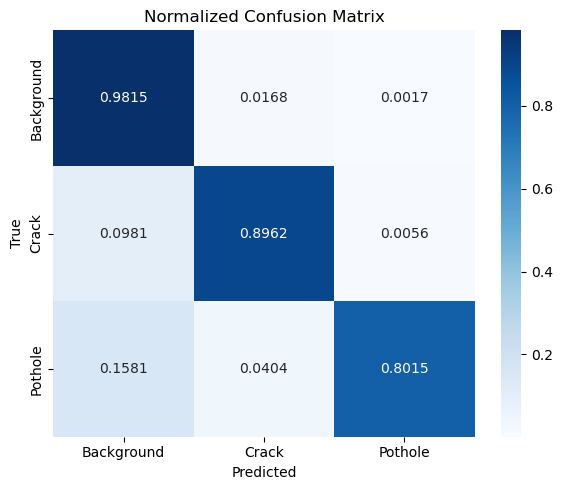


📋 Classification Report:
Class         Precision     Recall   F1-score        IoU    Support
------------------------------------------------------------
Background       0.9984     0.9815     0.9899     0.9799  144846686
Crack            0.3234     0.8962     0.4753     0.3117    1311951
Pothole          0.6657     0.8015     0.7273     0.5715     642003
------------------------------------------------------------
Average          0.6625     0.8931     0.7308     0.6210  146800640


In [15]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_30.pth"))
compute_metrics(model, test_loader)  # Test on test set

In [17]:
import torch
from collections import Counter
from tqdm import tqdm

NUM_CLASSES = 3  # Adjust based on your dataset

def get_class_distribution(dataloader):
    pixel_counts = Counter()

    for _, masks in tqdm(dataloader, desc="Analyzing Dataset Balance"):
        masks = masks.view(-1)  # Flatten mask
        classes, counts = torch.unique(masks, return_counts=True)
        for c, count in zip(classes.tolist(), counts.tolist()):
            pixel_counts[c] += count

    total_pixels = sum(pixel_counts.values())
    print("\n📊 Class Distribution:")
    for cls in range(NUM_CLASSES):
        count = pixel_counts.get(cls, 0)
        percentage = 100 * count / total_pixels
        print(f"Class {cls}: {count:,} pixels ({percentage:.2f}%)")

    return pixel_counts

get_class_distribution(train_loader)


Analyzing Dataset Balance: 100%|█████████████████████████████████████████████████████| 224/224 [01:52<00:00,  1.99it/s]


📊 Class Distribution:
Class 0: 1,156,000,948 pixels (98.65%)
Class 1: 10,947,821 pixels (0.93%)
Class 2: 4,834,911 pixels (0.41%)


Counter({0: 1156000948, 1: 10947821, 2: 4834911})

In [19]:
get_class_distribution(val_loader)

Analyzing Dataset Balance: 100%|███████████████████████████████████████████████████████| 28/28 [00:09<00:00,  2.97it/s]


📊 Class Distribution:
Class 0: 144,257,877 pixels (98.71%)
Class 1: 1,386,359 pixels (0.95%)
Class 2: 501,044 pixels (0.34%)


Counter({0: 144257877, 1: 1386359, 2: 501044})

In [20]:
get_class_distribution(test_loader)

Analyzing Dataset Balance: 100%|███████████████████████████████████████████████████████| 28/28 [00:09<00:00,  2.98it/s]


📊 Class Distribution:
Class 0: 144,846,686 pixels (98.67%)
Class 1: 1,311,951 pixels (0.89%)
Class 2: 642,003 pixels (0.44%)


Counter({0: 144846686, 1: 1311951, 2: 642003})

In [24]:
import torch; print(torch.version.cuda)
torch.cuda.is_available()

12.1


True

## Final Evaluation

In [12]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Standardized Confusion Matrix")
    plt.tight_layout()
    plt.show()

C:\Users\SHREY\AppData\Local\Temp\ipykernel_1896\2587256962.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9863
Per-class Accuracy:
  Background: 0.9885
  Crack: 0.8456
  Pothole: 0.7842
IoU per class:
  Background: 0.9864
  Crack: 0.3925
  Pothole: 0.6121
Mean IoU: 0.6637

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9885  0.0103  0.0012
Crack     : 0.1490  0.8456  0.0054
Pothole   : 0.1809  0.0349  0.7842


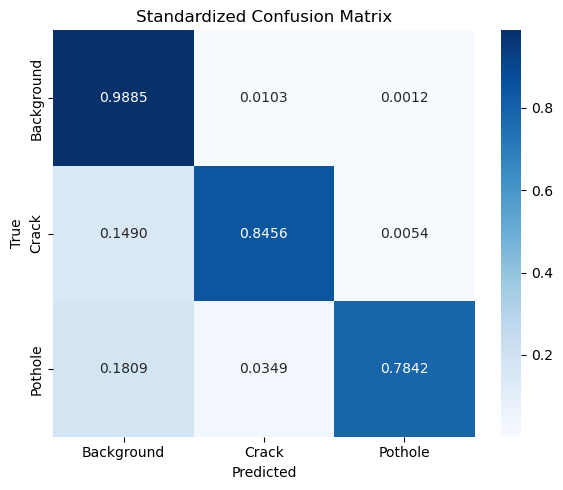

In [13]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_60.pth"))
compute_metrics(model, test_loader)  # Test on test set